### dev paincontrol

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [3]:
from compare_paincontrol import fit_bp, make_data_paincontrol
from compare_hyperparams import load_feats, feature_importance, load_modZ, load_cv
from compare_bfl_qsidp import load_qscode, match_question

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [4]:
curr_dir = '/well/seymour/users/uhu195/python/extract_npy'
cv_dir = os.path.join(curr_dir, 'cv_results', 'paincontrol')

In [5]:
df = load_cv(cv_dir)

    fit_time  score_time  test_accuracy   test_f1  test_roc_auc  bestIC  \
0  22.729138    0.109423       0.527656  0.506422      0.536811     500   
1  22.745637    0.109460       0.512730  0.524422      0.539679     500   
2  22.690197    0.109826       0.519754  0.504080      0.529627     500   
3  22.493965    0.108120       0.486392  0.510460      0.490044     500   
4  49.582270    0.116902       0.511853  0.509700      0.528974     500   

        qsidp  
0        None  
1        None  
2        None  
3        None  
4  ['t1vols']  


In [6]:
df.shape

(1856, 7)

In [7]:
df.iloc[df['test_roc_auc'].argmax()]

fit_time          17.372974
score_time         0.066584
test_accuracy      0.648815
test_f1            0.681529
test_roc_auc       0.700607
bestIC                  200
qsidp            ['mental']
Name: 16, dtype: object

In [8]:
df.iloc[df['test_accuracy'].argmax()]

fit_time                                      11.257381
score_time                                      0.07399
test_accuracy                                  0.658472
test_f1                                        0.666094
test_roc_auc                                   0.681232
bestIC                                              100
qsidp            ['demographic', 'lifestyle', 'mental']
Name: 57, dtype: object

In [9]:
df_g = df.groupby(['bestIC', 'qsidp'])['test_roc_auc', 'test_accuracy'].mean().rename(columns={'test_roc_auc':'auc', 'test_accuracy':'acc'})

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [10]:
df_g.iloc[df_g['auc'].argmax()]

auc    0.683399
acc    0.632572
Name: (200, ['t2star', 'taskfmri', 'mental']), dtype: float64

In [11]:
df_g.iloc[df_g['acc'].argmax()]

auc    0.673607
acc    0.639157
Name: (30, ['cognitive', 'lifestyle', 'mental']), dtype: float64

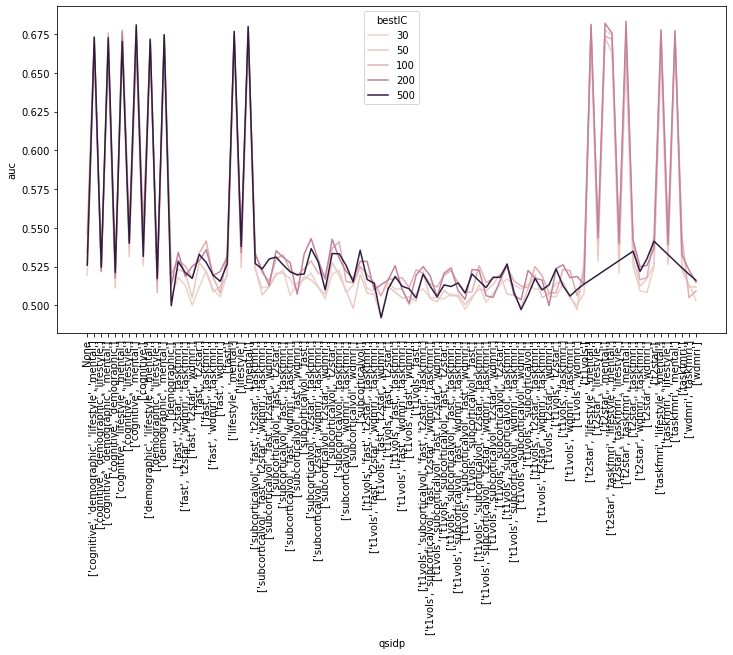

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
_ = sns.lineplot(data=df_g, x='qsidp', y='auc', hue='bestIC', ax=ax)
_ = plt.xticks(rotation=90)

#### check importance

In [5]:
bestIC = 200
qs_ls = ['lifestyle', 'mental']
idp_ls = None

In [28]:
bestIC = 200
qs_ls = ['mental']
idp_ls = ['t2star', 'taskfmri']

In [35]:
bestIC = 100
qs_ls = None #['demographic', 'lifestyle', 'mental']
idp_ls = None

In [36]:
bp = fit_bp(bestIC=bestIC, qs_ls=qs_ls, idp_ls=idp_ls, feat_scaler=True, feat_balance=True, fit_n=10)

[I 2022-02-18 11:02:02,749] A new study created in memory with name: no-name-770fc1f0-eba1-43ab-8cc1-c20d73afb433


df_bfl_qsidp shape=(4558, 103)
(4558, 100)
(3417, 100) (3417,)


[I 2022-02-18 11:02:09,689] Trial 0 finished with value: 0.5294005395171705 and parameters: {'max_depth': 14, 'n_estimators': 100, 'max_features': 0.3149091641686803, 'min_samples_split': 12, 'min_samples_leaf': 13, 'max_samples': 0.7807896205048566}. Best is trial 0 with value: 0.5294005395171705.
[I 2022-02-18 11:02:12,826] Trial 1 finished with value: 0.527356146993806 and parameters: {'max_depth': 12, 'n_estimators': 125, 'max_features': 0.2171410005883621, 'min_samples_split': 4, 'min_samples_leaf': 12, 'max_samples': 0.70032889866242}. Best is trial 0 with value: 0.5294005395171705.
[I 2022-02-18 11:02:14,183] Trial 2 finished with value: 0.5244314824137101 and parameters: {'max_depth': 9, 'n_estimators': 25, 'max_features': 0.24378025685452775, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9367485646953669}. Best is trial 0 with value: 0.5294005395171705.
[I 2022-02-18 11:02:23,719] Trial 3 finished with value: 0.5279484668082033 and parameters: {'max_depth': 9

In [37]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**bp)

In [38]:
# load bfl
df_bfl_qsidp = make_data_paincontrol(bestIC=bestIC, qs_ls=qs_ls, idp_ls=idp_ls)
# retrain params
X_train, y_train, X_valid, y_valid = load_feats(df_bfl_qsidp, bestIC, test_size=0.25, dummies=False,
                              train=True, balance=True, scaler=True)

df_bfl_qsidp shape=(4558, 103)
(4558, 100)


In [39]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, max_features=0.2780314588208761,
                       max_samples=0.888074506813658, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=50)

In [40]:
preds = clf.predict(X_train)
print(len(preds))
print(balanced_accuracy_score(y_train, preds))
print(sum(y_train==preds)/len(y_train))

3417
0.6224686293667772
0.6224758560140474


In [41]:
preds = clf.predict(X_valid)
print(len(preds))
print(balanced_accuracy_score(y_valid, preds))
print(sum(y_valid==preds)/len(y_valid))

1139
0.5487373970955508
0.5487269534679543


In [42]:
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1])

0.5447877162149662

In [43]:
output_ls = ['label', 'eid', 'bmrc']
tmp = df_bfl_qsidp.drop(columns=output_ls)
feature_names = tmp.columns

In [44]:
# feature_imp = feature_importance(clf, feature_names)

In [45]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [46]:
feat_sorted = feat_importances.sort_values(ascending=False)

Text(0, 0.5, 'Mean decrease in impurity')

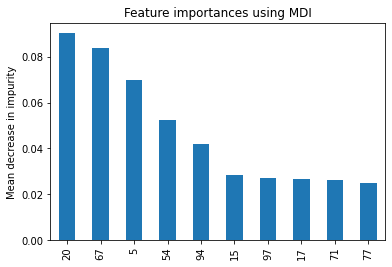

In [47]:
fig, ax = plt.subplots()
feat_sorted.iloc[:10].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [48]:
feats10 = feat_sorted.iloc[:10].index
match_question(feats10)

[]

#### visualising top feature

In [49]:
# data_dir = '/well/tracey/shared/fps-ukb/bigflica_output/output_paincontrol_500/Result_IC200/'
data_dir = '/well/tracey/shared/fps-ukb/bigflica_output/output_paincontrol_500/Result_IC100/'

In [50]:
def top_mods(data_dir, top_feat, mod_num=3, plot=True):
    """return top modalities given feature importance"""
    mod_contrib = np.load(os.path.join(data_dir, 'mod_contribution.npy')) # mod x feats
#     top_feat = int(feature_importance.index[0].split(' ')[1])
    print(f'top feature: {top_feat}')
    topIC = mod_contrib[:,top_feat]
    # load mod names
    mod_names = pd.read_csv('./sorted_feats.csv')
    plot_mod = mod_names.iloc[topIC.argsort()]
#     print(plot_mod.index.max())
    print('top modalities', plot_mod.iloc[-mod_num:])
    if plot:
        import matplotlib.pyplot as plt
        plt.subplots(figsize=(8,4))
        plt.bar(np.arange(len(topIC)), topIC[topIC.argsort()])
        plot_mod_names = plot_mod['modalities'].values
        plt.xticks(np.arange(len(plot_mod_names)), plot_mod_names, rotation=90)
    return top_feat, plot_mod.index[-mod_num:].values[::-1]

top feature: 20
top modalities    modalities
43     zstat5
34      cope2
40     zstat2
44      cope1
8      zstat1


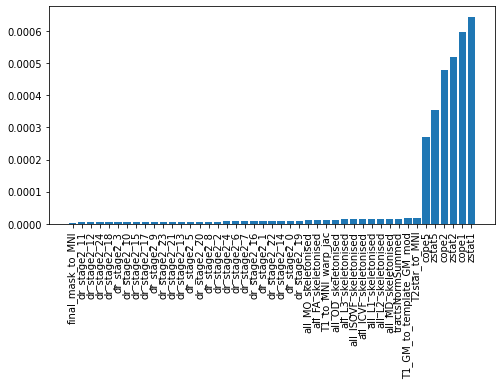

In [51]:
top_feat, mod_ls = top_mods(data_dir, top_feat=20, mod_num=5)

modality 32
(228453, 100)
modality 16
(228453, 100)
modality 7
(228453, 100)
modality 25
(228453, 100)
modality 19
(228453, 100)


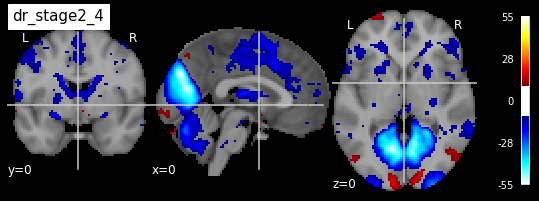

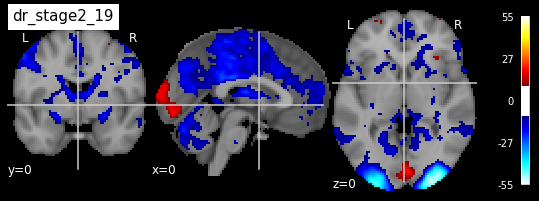

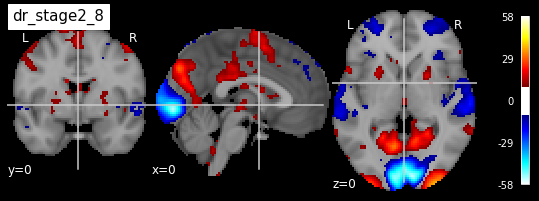

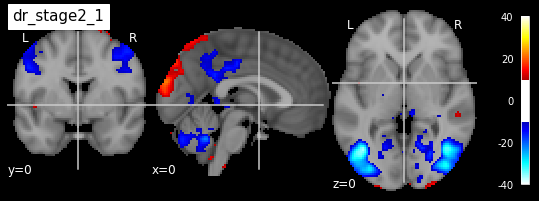

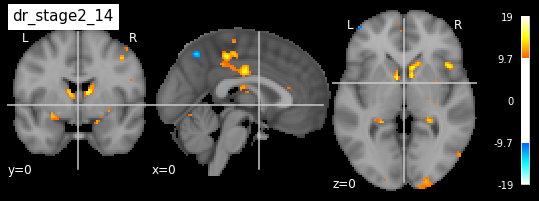

In [30]:
for mod in mod_ls:
    print(f'modality {mod}')
    reshape_z, mask_path = load_modZ(data_dir, modality_num=mod, feature_num=top_feat, plot_threshold=10)

top feature: 67
top modalities                 modalities
22     all_L1_skeletonised
3      all_L3_skeletonised
11     all_L2_skeletonised
36  all_ISOVF_skeletonised
28     all_MD_skeletonised


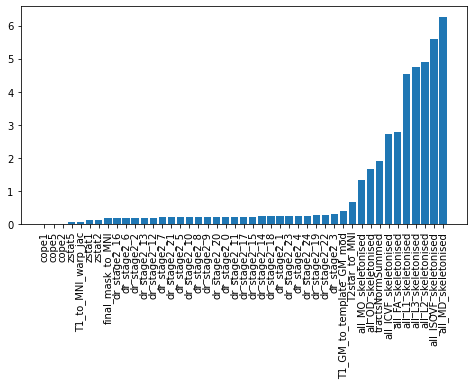

In [52]:
top_feat, mod_ls = top_mods(data_dir, top_feat=67, mod_num=5)

modality 28
(1827095, 100)
modality 36
(1827095, 100)
modality 11
(1827095, 100)
modality 3
(1827095, 100)
modality 22
(1827095, 100)


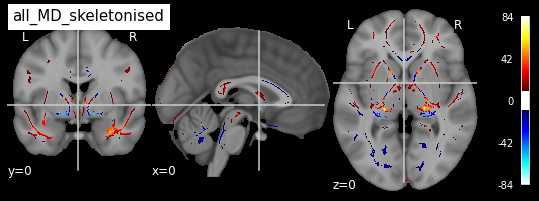

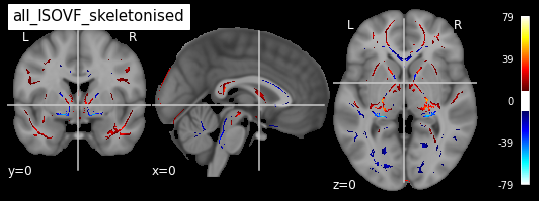

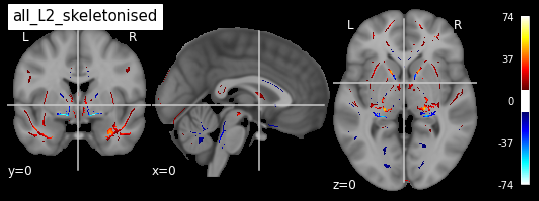

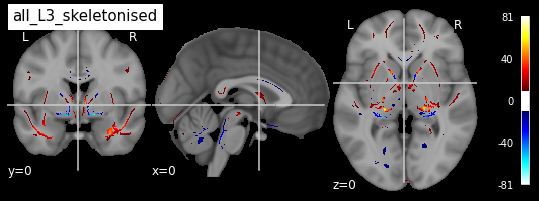

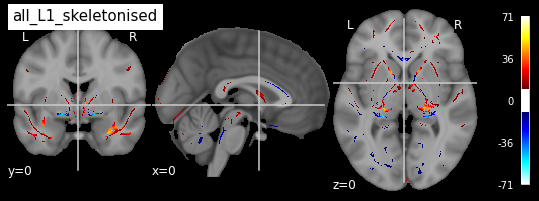

In [54]:
for mod in mod_ls:
    print(f'modality {mod}')
    reshape_z, mask_path = load_modZ(data_dir, modality_num=mod, feature_num=top_feat, plot_threshold=10)

In [27]:
bestIC = 30
qs_ls = ['cognitive', 'lifestyle', 'mental']
idp_ls = None

In [29]:
bp = fit_bp(bestIC=bestIC, qs_ls=qs_ls, idp_ls=idp_ls, feat_scaler=True, feat_balance=True, fit_n=10)

/gpfs3/well/seymour/users/uhu195/python/extract_npy/compare_paincontrol.py:64: DtypeWarning: Columns (863,867) have mixed types.Specify dtype option on import or set low_memory=False.
  df_bfl_qsidp = make_data_paincontrol(bestIC, qs_ls=qs_ls, idp_ls=idp_ls)
[I 2021-10-28 10:46:44,244] A new study created in memory with name: no-name-ceb86a25-a93c-40b3-ad8b-79a22cf0677f


df_qs_imputed_dum shape=(4558, 270)
df_bfl_qsidp shape=(4558, 302)
(4558, 299)
(3417, 299) (3417,)


[I 2021-10-28 10:46:48,908] Trial 0 finished with value: 0.6332986331502112 and parameters: {'max_depth': 2, 'n_estimators': 75, 'max_features': 0.21409882768022265, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_samples': 0.9639502810389797}. Best is trial 0 with value: 0.6332986331502112.
[I 2021-10-28 10:46:50,748] Trial 1 finished with value: 0.6382382794545733 and parameters: {'max_depth': 2, 'n_estimators': 125, 'max_features': 0.5555068523687441, 'min_samples_split': 13, 'min_samples_leaf': 13, 'max_samples': 0.7376802841912988}. Best is trial 1 with value: 0.6382382794545733.
[I 2021-10-28 10:46:59,679] Trial 2 finished with value: 0.6414755192715971 and parameters: {'max_depth': 13, 'n_estimators': 225, 'max_features': 0.5793415424340723, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_samples': 0.9340732710615782}. Best is trial 2 with value: 0.6414755192715971.
[I 2021-10-28 10:47:09,563] Trial 3 finished with value: 0.6391377027293221 and parameters: {'max_depth':

In [30]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**bp)

In [31]:
# load bfl
df_bfl_qsidp = make_data_paincontrol(bestIC=bestIC, qs_ls=qs_ls, idp_ls=idp_ls)
# retrain params
X_train, y_train, X_valid, y_valid = load_feats(df_bfl_qsidp, bestIC, test_size=0.25, dummies=False,
                              train=True, balance=True, scaler=True)

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (863,867) have mixed types.Specify dtype option on import or set low_memory=False.
  


df_qs_imputed_dum shape=(4558, 270)
df_bfl_qsidp shape=(4558, 302)
(4558, 299)


In [32]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=13, max_features=0.5793415424340723,
                       max_samples=0.9340732710615782, min_samples_leaf=9,
                       min_samples_split=14, n_estimators=225)

In [33]:
preds = clf.predict(X_train)
print(len(preds))
print(balanced_accuracy_score(y_train, preds))
print(sum(y_train==preds)/len(y_train))

3417
0.9125005310088621
0.9124963418203103


In [34]:
preds = clf.predict(X_valid)
print(len(preds))
print(balanced_accuracy_score(y_valid, preds))
print(sum(y_valid==preds)/len(y_valid))

1139
0.621624579903185
0.6215978928884986


In [35]:
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1])

0.6707643449572965

In [36]:
output_ls = ['label', 'eid', 'bmrc']
tmp = df_bfl_qsidp.drop(columns=output_ls)
feature_names = tmp.columns

In [37]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [38]:
feat_sorted = feat_importances.sort_values(ascending=False)

Text(0, 0.5, 'Mean decrease in impurity')

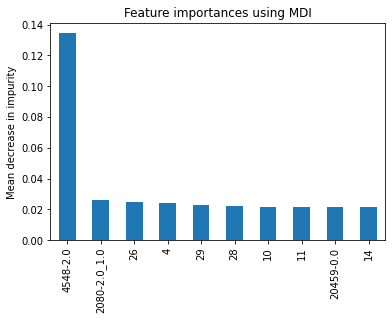

In [39]:
fig, ax = plt.subplots()
feat_sorted.iloc[:10].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [40]:
feats10 = feat_sorted.iloc[:10].index
match_question(feats10)

[array(['Health satisfaction'], dtype=object),
 array(['Frequency of tiredness / lethargy in last 2 weeks'], dtype=object),
 array(['General happiness with own health'], dtype=object)]

In [41]:
data_dir = '/well/tracey/shared/fps-ukb/bigflica_output/output_paincontrol_500/Result_IC30/'

top feature: 26
top modalities    modalities
8      zstat1
34      cope2
40     zstat2
37      cope5
43     zstat5


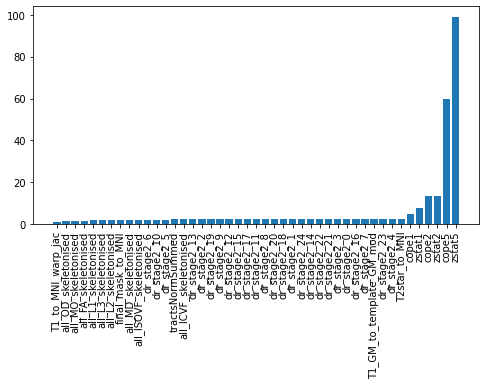

In [46]:
top_feat, mod_ls = top_mods(data_dir, top_feat=26, mod_num=5)

modality 43
(228453, 30)
modality 37
(228453, 30)
modality 40
(228453, 30)
modality 34
(228453, 30)
modality 8
(228453, 30)


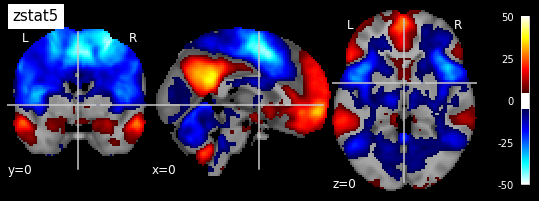

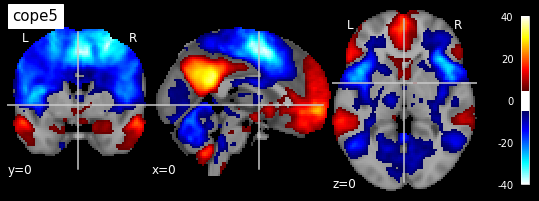

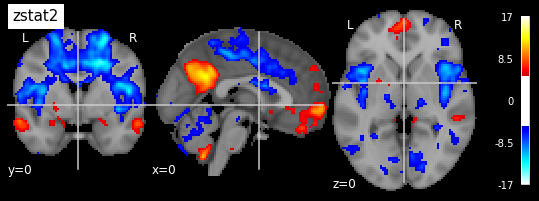

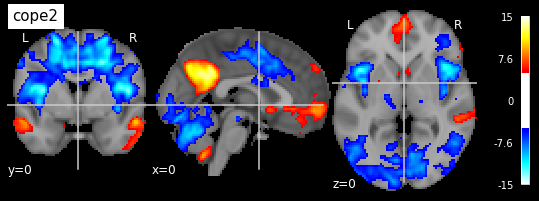

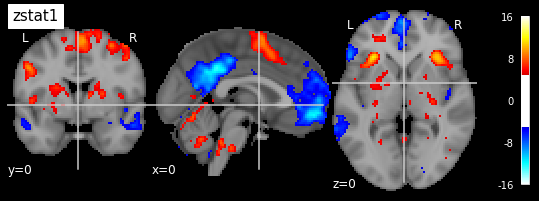

In [47]:
for mod in mod_ls:
    print(f'modality {mod}')
    reshape_z, mask_path = load_modZ(data_dir, modality_num=mod, feature_num=top_feat, plot_threshold=5)